# Facial landmarks with dlib, OpenCV, and Python

Facial landmarks are used to localize and represent salient regions of the face, such as:

* Eyes
* Eyebrows
* Nose
* Mouth
* Jawline

## What are facial landmarks?
<image src="images/facial_landmarks_dlib_example.jpeg">

Detecting facial landmarks is a subset of the shape prediction problem. Given an input image (and normally an ROI that specifies the object of interest), a shape predictor attempts to localize key points of interest along the shape.

In the context of facial landmarks, our goal is detect important facial structures on the face using shape prediction methods.

Detecting facial landmarks is therefore a two step process:

* Step #1: Localize the face in the image.
* Step #2: Detect the key facial structures on the face ROI.

Face detection (Step #1) can be achieved in a number of ways.

We could use OpenCV’s built-in Haar cascades.

We might apply a pre-trained HOG + Linear SVM object detector specifically for the task of face detection.

Or we might even use deep learning-based algorithms for face localization.

n either case, the actual algorithm used to detect the face in the image doesn’t matter. Instead, what’s important is that through some method we obtain the face bounding box (i.e., the (x, y)-coordinates of the face in the image).

Given the face region we can then apply Step #2: detecting key facial structures in the face region.

There are a variety of facial landmark detectors, but all methods essentially try to localize and label the following facial regions:

* Mouth
* Right eyebrow
* Left eyebrow
* Right eye
* Left eye
* Nose
* Jaw

The facial landmark detector included in the dlib library is an implementation of the One Millisecond Face Alignment with an Ensemble of Regression Trees paper by Kazemi and Sullivan (2014).

This method starts by using:

1. A training set of labeled facial landmarks on an image. These images are manually labeled, specifying specific (x, y)-coordinates of regions surrounding each facial structure.
2. Priors, of more specifically, the probability on distance between pairs of input pixels.

Given this training data, an ensemble of regression trees are trained to estimate the facial landmark positions directly from the pixel intensities themselves (i.e., no “feature extraction” is taking place).

The end result is a facial landmark detector that can be used to detect facial landmarks in real-time with high quality predictions.

For more information and details on this specific technique, be sure to read the paper by Kazemi and Sullivan linked to above, along with the official dlib announcement.

## Understanding dlib’s facial landmark detector
The pre-trained facial landmark detector inside the dlib library is used to estimate the location of 68 (x, y)-coordinates that map to facial structures on the face.

The indexes of the 68 coordinates can be visualized on the image below:
<image src="images/facial_landmarks_68markup-768x619.jpeg">

Figure 2: Visualizing the 68 facial landmark coordinates from the iBUG 300-W dataset (higher resolution).
These annotations are part of the 68 point iBUG 300-W dataset which the dlib facial landmark predictor was trained on.

It’s important to note that other flavors of facial landmark detectors exist, including the 194 point model that can be trained on the HELEN dataset.


### Import Packages

In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Facial landmarks with dlib, OpenCV, and Python

In [4]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,
#	help="path to facial landmark predictor")
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"shape_predictor": "pyimagesearch/shape_predictor_68_face_landmarks.dat",
	"image": "data/FacialLandmark/example_01.jpg"
}

In [5]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

# load the input image, resize it, and convert it to grayscale
image = cv2.imread(args["image"])
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
# 1 is the number of image pyramid layers to apply when upscaling the image prior to applying the detector (this it the equivalent of computing cv2.pyrUp N number of times on the image).
# The benefit of increasing the resolution of the input image prior to face detection is that it may allow us to detect more faces in the image — the downside is that the larger the input image, the more computaitonally expensive the detection process is.
rects = detector(gray, 1)

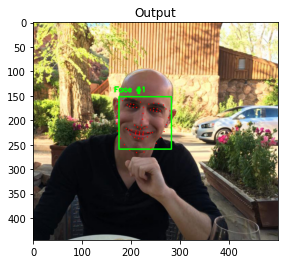

In [6]:
# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region, then
	# convert the facial landmark (x, y)-coordinates to a NumPy
	# array
	shape = predictor(gray, rect)
	shape = face_utils.shape_to_np(shape)

	# convert dlib's rectangle to a OpenCV-style bounding box
	# [i.e., (x, y, w, h)], then draw the face bounding box
	(x, y, w, h) = face_utils.rect_to_bb(rect)
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# show the face number
	cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

	# loop over the (x, y)-coordinates for the facial landmarks
	# and draw them on the image
	for (x, y) in shape:
		cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

# show the output image with the face detections + facial landmarks
plt_imshow("Output", image)

# Detect eyes, nose, lips, and jaw with dlib, OpenCV, and Python
## Facial landmark indexes for face regions

The facial landmark detector implemented inside dlib produces 68 (x, y)-coordinates that map to specific facial structures. These 68 point mappings were obtained by training a shape predictor on the labeled iBUG 300-W dataset.

Below we can visualize what each of these 68 coordinates map to:

<image src="images/facial_landmarks_68markup-768x619.jpeg">

Examining the image, we can see that facial regions can be accessed via simple Python indexing (assuming zero-indexing with Python since the image above is one-indexed):

* The mouth can be accessed through points [48, 68].
* The right eyebrow through points [17, 22].
* The left eyebrow through points [22, 27].
* The right eye using [36, 42].
* The left eye with [42, 48].
* The nose using [27, 35].
* And the jaw via [0, 17].

These mappings are encoded inside the FACIAL_LANDMARKS_IDXS dictionary inside face_utils of the imutils library.

## Visualizing facial landmarks with OpenCV and Python
A slightly harder task is to visualize each of these facial landmarks and overlay the results on an input image.

To accomplish this, we’ll need the visualize_facial_landmarks function, already included in the imutils library:



### Extracting parts of the face using dlib, OpenCV, and Python

In [7]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-p", "--shape-predictor", required=True,
# 	help="path to facial landmark predictor")
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "shape_predictor": "pyimagesearch/shape_predictor_68_face_landmarks.dat",
    "image": "data/FacialLandmark/example_01.jpg"
}

In [8]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

# load the input image, resize it, and convert it to grayscale
image = cv2.imread(args["image"])
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)

In [9]:
# initialize unique color for each facial landmark region
colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
    (168, 100, 168), (158, 163, 32),
    (163, 38, 32), (180, 42, 220),
    (100, 68, 109)]

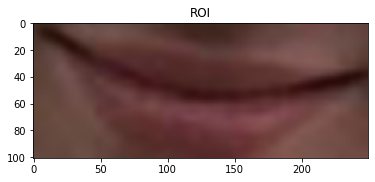

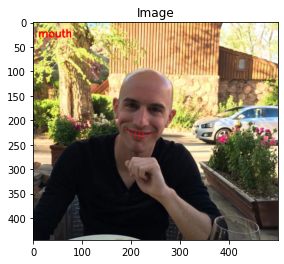

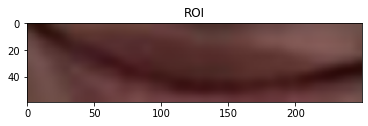

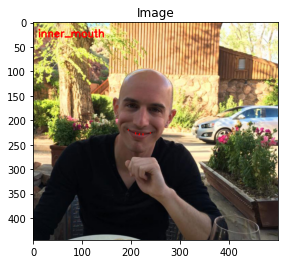

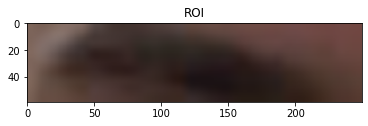

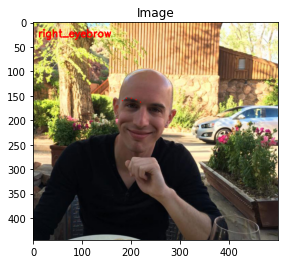

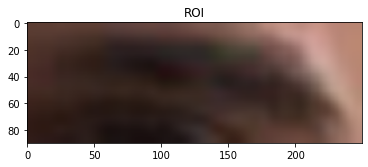

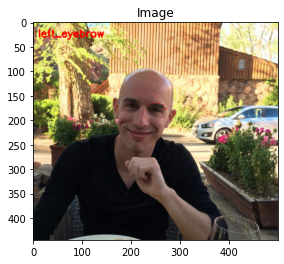

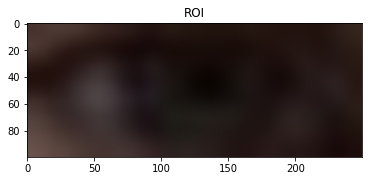

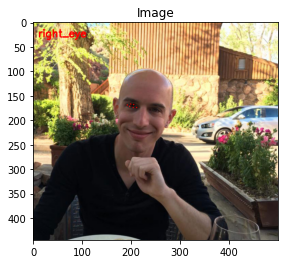

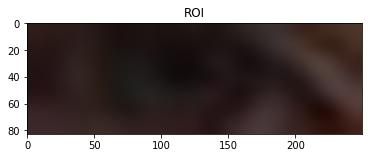

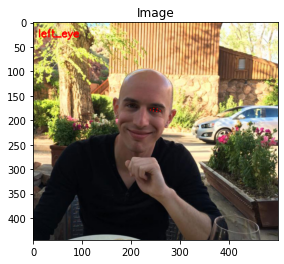

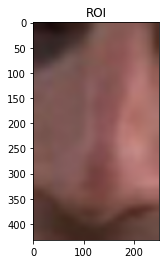

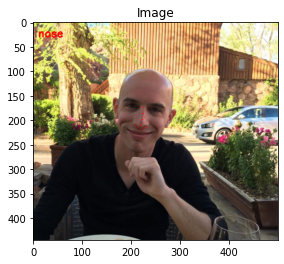

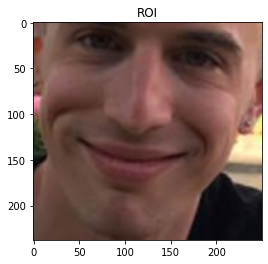

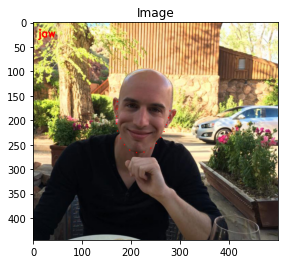

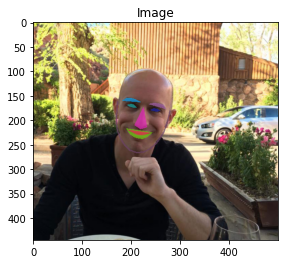

In [10]:
# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region, then
	# convert the landmark (x, y)-coordinates to a NumPy array
	shape = predictor(gray, rect)
	shape = face_utils.shape_to_np(shape)
	
    # loop over the face parts individually
	for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
		
        # clone the original image so we can draw on it, then
		# display the name of the face part on the image
		clone = image.copy()
		cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
			0.7, (0, 0, 255), 2)
		
        # loop over the subset of facial landmarks, drawing the
		# specific face part
		for (x, y) in shape[i:j]:
			cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)
   
        # extract the ROI of the face region as a separate image
		(x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
		roi = image[y:y + h, x:x + w]
		roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)
		
        # show the particular face part
		plt_imshow("ROI", roi)
		plt_imshow("Image", clone)
	
    # visualize all facial landmarks with a transparent overlay
	output = face_utils.visualize_facial_landmarks(image, shape, colors=colors)
	plt_imshow("Image", output)

# Real-time facial landmark detection with OpenCV, Python, and dlib

# Facial landmarks in video streams
Let’s go ahead and get this facial landmark example started.

Open up a new file, name it video_facial_landmarks.py , and insert the following code:

In [ ]:
# import the necessary packages
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2

In [ ]:
'''
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=True,
	help="path to facial landmark predictor")
ap.add_argument("-r", "--picamera", type=int, default=-1,
	help="whether or not the Raspberry Pi camera should be used")
args = vars(ap.parse_args())
'''

In [ ]:
'''
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])
'''

In [ ]:
'''
# initialize the video stream and allow the cammera sensor to warmup
print("[INFO] camera sensor warming up...")
vs = VideoStream(usePiCamera=args["picamera"] > 0).start()
time.sleep(2.0)
'''

In [ ]:
'''
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream, resize it to
	# have a maximum width of 400 pixels, and convert it to
	# grayscale
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
    # detect faces in the grayscale frame
	rects = detector(gray, 0)

    # loop over the face detections
	for rect in rects:
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
		
        # loop over the (x, y)-coordinates for the facial landmarks
		# and draw them on the image
		for (x, y) in shape:
			cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
	  
	# show the frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

    # do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()
'''

# (Faster) Facial landmark detector with dlib

## Dlib’s 5-point facial landmark detector
<image src="images/faster_facial_landmarks_5_vs_68.jpeg">

Figure 1 above visualizes the difference between dlib’s new 5-point facial landmark detector versus the original 68-point detector.

While the 68-point detector localizes regions along the eyes, eyebrows, nose, mouth, and jawline, the 5-point facial landmark detector reduces this information to:

* 2 points for the left eye
* 2 points for the right eye
* 1 point for the nose

The most appropriate use case for the 5-point facial landmark detector is face alignment.

In terms of speedup, I found the new 5-point detector to be 8-10% faster than the original version, but the real win here is model size: 9.2MB versus 99.7MB, respectively (over 10x smaller).

The real win in terms of speedup will be to determine which face detector you should use. Some face detectors are faster (but potentially less accurate) than others. If you remember back to our drowsiness detection series:

* Drowsiness detection with OpenCV
* Raspberry Pi: Facial landmarks + drowsiness detection with OpenCV and dlib

You’ll recall that we used the more accurate HOG + Linear SVM face detector for the laptop/desktop implementation, but required a less accurate but faster Haar cascade to achieve real-time speed on the Raspberry Pi.

In general, you’ll find the following guidelines to be a good starting point when choosing a face detection model:

* Haar cascades: Fast, but less accurate. Can be a pain to tune parameters.
* HOG + Linear SVM: Typically (significantly) more accurate than Haar cascades with less false positives. Normally less parameters to tune at test time. Can be slow compared to Haar cascades.
*Deep learning-based detectors: Significantly more accurate and robust than Haar cascades and HOG + Linear SVM when trained correctly. Can be very slow depending on depth and complexity of model. Can be sped up by performing inference on GPU (you can see an OpenCV deep learning face detector in this post).

Keep these guidelines in mind when building your own applications that leverage both face detection and facial landmarks.

### Implementing facial landmarks with dlib, OpenCV, and Python

In [12]:
# first, let's get a video on which we can run facial landmark detector
#!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/Facemask_detection.mp4

--2021-05-17 16:24:06--  https://colab-notebook-videos.s3-us-west-2.amazonaws.com/Facemask_detection.mp4
Resolving colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)... 52.218.182.41
Connecting to colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)|52.218.182.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38426787 (37M) [video/mp4]
Saving to: ‘Facemask_detection.mp4’

Facemask_detection. 100%[===================>]  36.65M  2.25MB/s    in 22s     

2021-05-17 16:24:29 (1.65 MB/s) - ‘Facemask_detection.mp4’ saved [38426787/38426787]



In [13]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,
#	help="path to facial landmark predictor")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"shape_predictor": "pyimagesearch/shape_predictor_5_face_landmarks.dat",
	"input": "data/Facemask_detection.mp4",
	"output": "output/Facemask_detection.avi"
}

In [14]:
# initialize dlib's face detector (HOG-based) and then create the
# facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

# grab a reference to the video file and initialize pointer to output
# video file
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["input"])
writer = None

[INFO] loading facial landmark predictor...
[INFO] opening video file...


In [ ]:
'''
# initialize the video stream and sleep for a bit, allowing the
# camera sensor to warm up
print("[INFO] camera sensor warming up...")
vs = VideoStream(src=1).start()

# vs = VideoStream(usePiCamera=True).start() # Raspberry Pi
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream, resize it to
	# have a maximum width of 400 pixels, and convert it to
	# grayscale
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
	# detect faces in the grayscale frame
	rects = detector(gray, 0)
	
    # check to see if a face was detected, and if so, draw the total
	# number of faces on the frame
	if len(rects) > 0:
		text = "{} face(s) found".format(len(rects))
		cv2.putText(frame, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, (0, 0, 255), 2)

    # loop over the face detections
	for rect in rects:
		# compute the bounding box of the face and draw it on the
		# frame
		(bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
		cv2.rectangle(frame, (bX, bY), (bX + bW, bY + bH),
			(0, 255, 0), 1)
		
        # determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
 
		
        # loop over the (x, y)-coordinates for the facial landmarks
		# and draw each of them
		for (i, (x, y)) in enumerate(shape):
			cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
			cv2.putText(frame, str(i + 1), (x - 10, y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

    # show the frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

'''

In [15]:
# loop over the frames from the video stream
while True:
    # grab the next frame
	frame = vs.read()[1]

	# if we did not grab a frame then we have reached the end of the
	# video
	if frame is None:
		break
    
	# resize the frame to have a maximum width of 400 pixels, and
    # convert it to grayscale
	frame = imutils.resize(frame, width=400)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
	# detect faces in the grayscale frame
	rects = detector(gray, 0)

	# check to see if a face was detected, and if so, draw the total
	# number of faces on the frame
	if len(rects) > 0:
		text = "{} face(s) found".format(len(rects))
		cv2.putText(frame, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, (0, 0, 255), 2)
  
    # loop over the face detections
	for rect in rects:
		# compute the bounding box of the face and draw it on the
		# frame
		(bX, bY, bW, bH) = face_utils.rect_to_bb(rect)
		cv2.rectangle(frame, (bX, bY), (bX + bW, bY + bH),
			(0, 255, 0), 1)

		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
 
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw each of them
		for (i, (x, y)) in enumerate(shape):
			cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)
			cv2.putText(frame, str(i + 1), (x - 10, y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
   
    # if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(frame.shape[1], frame.shape[0]), True)
  
	# if the writer is not None, write the frame with recognized
	# faces to disk
	if writer is not None:
		writer.write(frame)

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()